# Mountain Car Example

Let's see how to make this API work with Mountain Car! This reinforcement learning API requires 3 things to be defined before we start running algorithms:

+ BlackBoxModel: defines the problem--see below for an example!
+ Policy: this is where your domain knowledge comes in--define action space and feature functions
+ Solver: This is where the API takes over and you just specify what you want to use

In [1]:
include(joinpath("..","src","ReinforcementLearning.jl"))
using ReinforcementLearning
using ProfileView

## Define Black Box Model Functions

The BlackBoxModel type requires the following things to be defined:
+ `model`: a generic type that holds all your model parameters for a specific instance of your problem
+ `init(model,rng)`: generate an initial state
+ `observe(model,rng,state,action=None)`: return an observation based on your state (and action--this isn't quite ironed out yet)
+ `next_state(model,rng,state,action)`: generate a next state given your state, action and problem parameterization
+ `reward(model,rng,state,action)`: generate a reward based on your state and action and problem parameterization
+ `isterminal(model,state,action)`: return a boolean of whether a state (and action) is terminal or not

In [2]:
type MtnCarModel <: Model
    cost::Float64
end
MtnCarModel() = MtnCarModel(-1.)

MtnCarModel

In [3]:
init2(m::MtnCarModel,rng::AbstractRNG) = [1.8*rand()-1.2;0.14*rand()-0.07]
init1(m::MtnCarModel,rng::AbstractRNG) = [-0.5;0.]

init1 (generic function with 1 method)

In [4]:
function next_state(rng::AbstractRNG,model::MtnCarModel,s::Array{Float64,1},a::Float64)
    x,v = s
    v_ = v + a*0.001+cos(3*x)*-0.0025
    v_ = max(min(0.07,v_),-0.07)
    x_ = x+v_
    #inelastic boundary
    if x_ < -1.2
        x_ = -1.2
        v_ = 0.
    end
    return [x_;v_]
end

next_state (generic function with 1 method)

In [5]:
isterminal(rng::AbstractRNG,m::MtnCarModel,s::Array{Float64,1},a::Float64) = s[1] >= 0.5

isterminal (generic function with 1 method)

In [6]:
reward(rng::AbstractRNG,m::MtnCarModel,s::Array{Float64,1},a::Float64) = isterminal(rng,m,s,a) ? 0.: m.cost

reward (generic function with 1 method)

We now define the BlackBoxModel type. Note that we do not include an observation function in the constructor--in this case, it uses a default identity observation model

In [7]:
bbm = BlackBoxModel(MtnCarModel(),init1,next_state,reward,isterminal) 

ReinforcementLearning.BlackBoxModel{Array{Float64,1}}([-0.5,0.0],isterminal,next_state,ReinforcementLearning.__observe,reward,init1,MtnCarModel(-1.0),MersenneTwister(Base.dSFMT.DSFMT_state(Int32[-1128627394,1073450412,-1865543919,1073610501,363445882,1073515591,-1159453797,1073183925,-406866903,1073009405  …  -271439765,1073490720,1153361283,1072929539,1346397742,2069239478,-1252511126,1992602127,382,0]),[6.91344e-310,0.0,6.91344e-310,0.0,6.91344e-310,0.0,6.91344e-310,0.0,6.91344e-310,0.0  …  NaN,3.14296e-316,NaN,2.122e-314,6.91343e-310,NaN,6.91346e-310,6.91343e-310,NaN,2.122e-314],382,UInt32[0x0001e14d]))

## Setting Up the Policy

In general for a policy, we have to define an ActionSpace (which we require to be exactly or a subset of the true action space), and feature function, which maps the state into a vector.

In [8]:
A = DiscreteActionSpace([-1.;0.;1.]) #

ReinforcementLearning.DiscreteActionSpace{Float64}([-1.0,0.0,1.0])

Tile coding is provided (the API for tilecoding needs work, however) for a quick and dirty function approximator in the continuous domain. For concreteness/generality, we include a function `cast_mc_state`, which in the most general case, will convert whatever state representation you have into an array of numbers

In [9]:
#for concreteness, this function converts statespace to an array
"""
cast_mc_state(x)=x
__feature_function_ = generate_tilecoder(5,5,A,[-1.2;-0.07],[0.6;0.07])
feature_function(s,a)=__feature_function_(cast_mc_state(s),a)
"""
nb_bins = 100
function feature_function(s::Array{Float64,1})
    x_ind = ReinforcementLearning.bin(s[1],-1.2,0.6,nb_bins)
    v_ind = ReinforcementLearning.bin(s[2],-0.07,0.07,nb_bins)
    ind = nb_bins*(x_ind - 1) + v_ind + 1
    return sparsevec([ind],[1.],nb_bins*nb_bins)
end

feature_function (generic function with 1 method)

In [10]:
policy = EpsilonGreedyPolicy(feature_function,A,rng=MersenneTwister(3234),eps=0.1)

ReinforcementLearning.EpsilonGreedyPolicy(MersenneTwister(Base.dSFMT.DSFMT_state(Int32[-221350187,1072739794,2129820112,1073023570,-830582303,1073167925,-438527054,1072733782,-2040260864,1073622770  …  -1839575433,1072789267,-1087258609,1073636821,-1794186335,275674027,-1351324733,828802335,382,-1]),[6.91344e-310,0.0,6.91344e-310,0.0,2.44054e-312,3.30511e-316,3.30524e-316,3.30511e-316,2.44046e-312,3.30511e-316  …  2.41916e-312,3.29803e-316,3.29875e-316,3.29789e-316,2.27054e-312,3.29803e-316,3.2974e-316,3.29751e-316,6.95253e-310,3.29803e-316],382,UInt32[0x00000ca2]),ReinforcementLearning.DiscreteActionSpace{Float64}([-1.0,0.0,1.0]),feature_function,0.1,ReinforcementLearning.NullFeatureExpander{Float64}(Dict(0.0=>2,-1.0=>1,1.0=>3)))

## Choose and Set up your Solver

Currently, the following solvers are supported:
+ Forgetful LSTD(\lambda) / LS-SARSA (untested)
+ SARSA(\lamda) (untested)
+ Q(\lambda) (unimplemented)
+ GQ(\lambda) (unimplemented)
+ Double Q learning (untested)
+ Deterministic Policy Gradient (unimplemented)
+ (Natural) Actor-Critic (unimplemented
+ LSPI/Batch TD
+ True Online TD

We just ask that you know a-priori how big your feature vectors are to make initialization easy

In [29]:
#there might be a smart way to stick this into a constructor, but for now...
nb_features = length(ReinforcementLearning.expand(policy.exp,policy.feature_function(bbm.state),domain(A)[1]))
#updater = ForgetfulLSTDParam(nb_features,alpha=0.001/3)
updater = SARSAParam(nb_features,lambda=0.7,init_method="one",trace_type="replacing")
#updater = TrueOnlineTDParam(nb_features,lambda=0.95,init_method="unif_rand")
#mem_size = 50
#updater = LSPIParam(nb_features,mem_size,del=0.01,discount=0.99)

ReinforcementLearning.SARSAParam(0.7,[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],30000x1 sparse matrix with 0 Float64 entries:,true)

## Actually set up the real solver

Some random cool things supported include:
+ minibatching
+ experience replay
+ adaptive learning rates, e.g.:
    * momentum
    * nesterov momentum
    * rmsprop
    * adagrad
    * adadelta
    * adam
+ simulated annealing (probably shouldn't support this)


In [30]:
solver = Solver(updater,
                lr=0.01,
                nb_episodes= 100,
                nb_timesteps=10000,
                discount=0.99,
                annealer=NullAnnealer(),
                mb=NullMinibatcher(),
                er=NullExperienceReplayer(),
                display_interval=1)
#Profile.clear()
#Profile.init(n=100000)

ReinforcementLearning.Solver(0.01,100,10000,0.99,MersenneTwister(Base.dSFMT.DSFMT_state(Int32[-91462860,1072912861,204480478,1073329743,-890684795,1073513382,-903505016,1072806168,338829527,1072705478  …  62751789,1073482140,1955135002,1073102886,-1859048011,1705189642,1572702505,83218407,382,0]),[4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314,1.67982e-322,4.24399e-314,4.24399e-314  …  4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314,4.24399e-314],382,UInt32[0x00005d56]),ReinforcementLearning.NullAnnealer(),ReinforcementLearning.SARSAParam(0.7,[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],30000x1 sparse matrix with 0 Float64 entries:,true),ReinforcementLearning.NullMinibatcher(),ReinforcementLearning.NullExperienceReplayer(),true,1,true,ReinforcementLearning.SolverHistory([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,

Solving problem...
Episode 100, 	Avg Reward: -7398.414, 	Avg Abs. TD Error: 1.008, 	Avg Q-value: 0.921

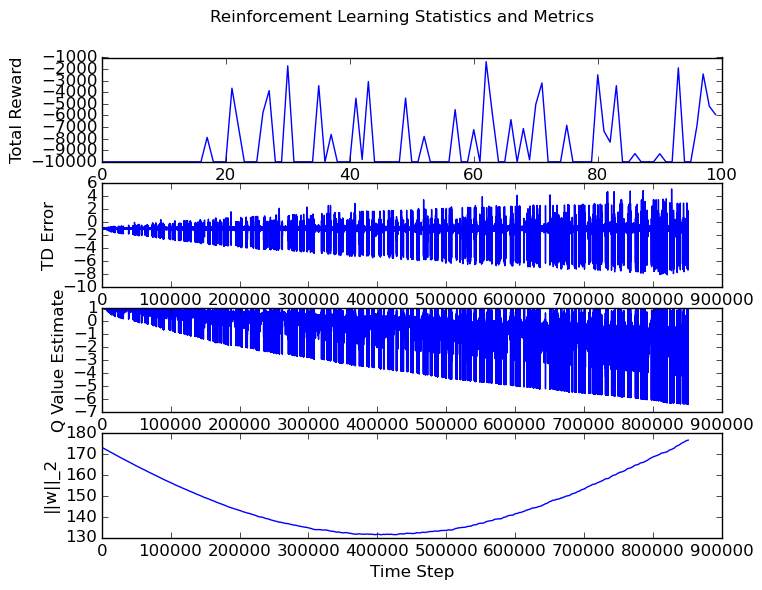

ReinforcementLearning.DiscretePolicy(ReinforcementLearning.DiscreteActionSpace{Float64}([-1.0,0.0,1.0]),feature_function,[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],ReinforcementLearning.NullFeatureExpander{Float64}(Dict(0.0=>2,-1.0=>1,1.0=>3)))

In [31]:
trained_policy = solve(solver,bbm,policy)

In [32]:
#ProfileView.view()

## Evaluate Policy
Basically just run a couple of simulations -- the simulator api is a subset of the stuff you see in solver

In [ ]:
sim = Simulator(discount=1.,nb_sim=50,nb_timesteps=10000) #stuff...

In [ ]:
#returns average reward for now...
bbm.init = init1
R_avg = simulate(sim,bbm,trained_policy)

In [ ]:
[dot(weights(updater),feature_function(bbm.state,a)) for a in domain(A)]

In [ ]:
function hand_ff(s::Array{Float64,1},a::Float64)
    if (s[2] > 0.) && (a > 0.)
        return [1.]
    elseif (s[2] <= 0.) && (a < 0.)
        return [1.]
    end
    return [0.]
end
hand_weights = [1.]
hand_policy = ReinforcementLearning.DiscretePolicy(A,hand_ff,hand_weights)

In [ ]:
simulate(sim,bbm,hand_policy)

In [ ]:
trained_policy

In [ ]:
X = zeros(sim.nb_timesteps)
V = zeros(sim.nb_timesteps)
A = zeros(sim.nb_timesteps)
R_tot = 0.
s = init(bbm)
a = action(trained_policy,s) #TODO: stuff
for t = 0:(sim.nb_timesteps-1)
    r, s_ = next(bbm,a)
    a_ = action(trained_policy,s_)
    X[t+1] = s_[1]
    V[t+1] = s_[2]
    A[t+1] = a_
    gamma = isterminal(bbm,a_) ? 0. : sim.discount^t
    R_tot += gamma*r
    if gamma == 0.
      break
    end
    #push the update frame up one time step as it were
    s = s_
    a = a_
end

subplot(311)
plot(X)
subplot(312)
plot(V)
subplot(313)
plot(A)

println(R_tot)

In [ ]:
import Iterators.product
nb_pts = 5
xs = linspace(-1.2,0.6,nb_pts)
vs = linspace(-0.07,0.07,nb_pts)
ss = product(xs,vs)
As = [xv=>action(trained_policy,[xv[1];xv[2]]) for xv in ss]

In [ ]:
action(trained_policy,bbm.state)

In [ ]:
trained_policy.weights == weights(updater)

In [ ]:
phi = feature_function(bbm.state,0.)
zeros(3000) + vec(updater.beta*phi*dot(updater.e,phi) + phi)

In [ ]:
zeros(3000)

In [ ]:
sum(updater.e)

In [ ]:
10*0.99*0.95

In [ ]:
phi = policy.feature_function(bbm.state,domain(A)[1])

In [ ]:
sum(max(zeros(3000),phi))

In [ ]:
updater.lambda

In [ ]:
norm((rand(3000)-0.5)/sqrt(3000))

In [ ]:
norm(rand(3000)-0.5)

In [ ]:
R_tot

In [ ]:
A

In [ ]:
nb_feat = length(policy.feature_function(bbm.state,0.))
Rs = zeros(100)
for ep in 1:100
    R = 0.
    updater.e = zeros(nb_feat)
    s = init(bbm)
    a = action(policy,updater,s)
    phi = policy.feature_function(s,a)
    for t = 1:5000
        r,s_ = next(bbm,a)
        a_ = action(policy,updater,s_)
        R += r
        
        phi_ = feature_function(s_,a_)
        gamma = isterminal(bbm,a_) ? 0. : 0.99
        q = dot(updater.w,phi)
        q_ = dot(updater.w,phi_)
        del = r + gamma*q_ - q
        updater.e = vec(max(phi,updater.e))
        dw = 0.01*updater.e*del
        updater.w  = vec(updater.w + dw)
        updater.e = vec(updater.e*0.95*gamma)
        
        if isterminal(bbm,a_)
            break
        end
        phi = phi_
    end
    Rs[ep] = R
end
plot(Rs)

In [ ]:
trained_policy = Policy(policy,updater)

In [ ]:

R = 0.
for ep in 1:100
    s = init(bbm)
    a = action(trained_policy,s)
    for t = 1:5000
        r,s_ = next(bbm,a)
        a_ = action(trained_policy,s_)
        R += r
        if isterminal(bbm,a_)
            break
        end
        a = a_
    end
end

R/100.